In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import numpy as np
import time
import matplotlib.pyplot
#%matplotlib inline

In [ ]:
def convert(imgf, labels, outfile, n):
    imgf = open(imgf, "rb")
    csvf = open(outfile, "w")
    labelf = open(labels, "rb")

    imgf.read(16)
    labelf.read(8)
    images = []

    for i in range(n):
        image = [ord(labelf.read(1))]
        for j in range(28*28):
            image.append(ord(imgf.read(1)))
        images.append(image)

    for image in images:
        csvf.write(",".join(str(pix) for pix in image)+"\n")
    imgf.close()
    labelf.close()
    csvf.close()


In [ ]:
mnist_train_x = "train-images.idx3-ubyte"
mnist_train_y = "train-labels.idx1-ubyte"
mnist_test_x = "t10k-images.idx3-ubyte"
mnist_test_y = "t10k-labels.idx1-ubyte"

In [ ]:
convert(mnist_train_x, mnist_train_y, "mnist_train.csv", 60000)
convert(mnist_test_x, mnist_test_y, "mnist_test.csv", 10000)

In [ ]:
train_file = open("mnist_train.csv", 'r')
train_list = train_file.readlines()
train_file.close()

In [ ]:
len(train_list)

60000

In [ ]:
#train_list[15]

In [ ]:
# reshape ve 28x28 va plot thanh 1 anh
all_values = train_list[15].split(',')
image_array = np.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [ ]:

# scale input to range 0.01 to 1.00
#scaled_input_train = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
# print(scaled_input_train)

In [ ]:
test_file = open("mnist_test.csv", 'r')
test_list = test_file.readlines()
test_file.close()

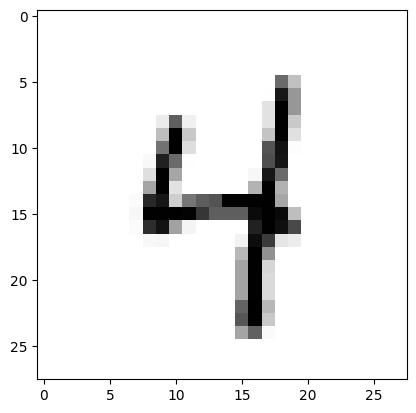

In [ ]:
all_values = test_list[19].split(',')
image_array = np.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [ ]:
class my_NeuralNetwork:
  def __init__(self, sizes, epochs, lr):
    self.sizes = sizes
    self.epochs = epochs
    self.lr = lr

    # number of nodes in each layer
    input_layer=self.sizes[0]
    hidden_1=self.sizes[1]
    hidden_2=self.sizes[2]
    output_layer=self.sizes[3]

    self.params =   {
    'W1': np.random.randn(hidden_1, input_layer) * np.sqrt(2. / input_layer),
    'W2': np.random.randn(hidden_2, hidden_1) * np.sqrt(2. / hidden_1),
    'W3': np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer),
      }

  def relu(self, x, derivative=False):
       if derivative:
          return np.where(x > 0, 1, 0)
       return np.maximum(0, x)

  def softmax(self, x, derivative=False):
      # Numerically stable with large exponentials
      exps = np.exp(x - x.max())
      if derivative:
          return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
      return exps / np.sum(exps, axis=0)

  def forward_pass(self, x_train):
      params = self.params

      # input layer activations becomes sample
      params['A0'] = x_train

      # input layer to hidden layer 1
      params['Z1'] = np.dot(params["W1"], params['A0'])
      params['A1'] = self.relu(params['Z1'])

      # hidden layer 1 to hidden layer 2
      params['Z2'] = np.dot(params["W2"], params['A1'])
      params['A2'] = self.relu(params['Z2'])

      # hidden layer 2 to output layer
      params['Z3'] = np.dot(params["W3"], params['A2'])
      params['A3'] = self.softmax(params['Z3'])

      return params['A3']

  def backward_pass(self, y_train, output):
      '''
          This is the backpropagation algorithm, for calculating the updates
          of the neural network's parameters.
      '''
      params = self.params
      change_w = {}

      # Calculate W3 update
      error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
      change_w['W3'] = np.outer(error, params['A2'])

      # Calculate W2 update
      error = np.dot(params['W3'].T, error) * self.relu(params['Z2'], derivative=True)
      change_w['W2'] = np.outer(error, params['A1'])

      # Calculate W1 update
      error = np.dot(params['W2'].T, error) * self.relu(params['Z1'], derivative=True)
      change_w['W1'] = np.outer(error, params['A0'])

      return change_w

  def update_network_parameters(self, changes_to_w):
      '''
          Update network parameters according to update rule from
          Stochastic Gradient Descent.
      '''

      for key, value in changes_to_w.items():
          self.params[key] -= self.lr * value

  def compute_accuracy(self, test_data, output_nodes):
      '''
          This function does a forward pass of x, then checks if the indices
          of the maximum value in the output equals the indices in the label
          y. Then it sums over each prediction and calculates the accuracy.
      '''
      predictions = []

      for x in test_list:
            all_values = x.split(',')
            inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
            targets = np.zeros(output_nodes) + 0.01
            targets[int(all_values[0])] = 0.99

            output = self.forward_pass(inputs)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(targets))
      return np.mean(predictions)

  def train(self, train_list, test_list, output_nodes, batch_size):
        start_time = time.time()

        for epoch in range(self.epochs):
            batch_start = 0
            while batch_start < len(train_list):
                batch_end = batch_start + batch_size
                batch = train_list[batch_start:batch_end]

                for record in batch:
                    all_values = record.split(',')
                    inputs = (np.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
                    targets = np.zeros(output_nodes) + 0.01
                    targets[int(all_values[0])] = 0.99

                    output = self.forward_pass(inputs)
                    changes_to_w = self.backward_pass(targets, output)
                    self.update_network_parameters(changes_to_w)

                batch_start = batch_end

            accuracy = self.compute_accuracy(test_list, output_nodes)
            print(f"Epoch: {epoch+1}, Time Spent: {time.time() - start_time:.2f}s, Accuracy: {accuracy * 100:.2f}%")


In [ ]:
mNN = my_NeuralNetwork(sizes=[784, 256, 256, 10], epochs=10, lr=0.001)
mNN.train(train_list, test_list, output_nodes=10, batch_size=32)

Epoch: 1, Time Spent: 116.84s, Accuracy: 87.80%
Epoch: 2, Time Spent: 229.53s, Accuracy: 90.48%
Epoch: 3, Time Spent: 342.53s, Accuracy: 91.48%
Epoch: 4, Time Spent: 455.66s, Accuracy: 92.01%
Epoch: 5, Time Spent: 571.40s, Accuracy: 92.47%
Epoch: 6, Time Spent: 685.20s, Accuracy: 92.81%
Epoch: 7, Time Spent: 797.85s, Accuracy: 93.16%
Epoch: 8, Time Spent: 909.86s, Accuracy: 93.40%
Epoch: 9, Time Spent: 1024.03s, Accuracy: 93.55%
Epoch: 10, Time Spent: 1136.37s, Accuracy: 93.71%
